# Lab on Stochastic Linear Bandits :

We provide the environment to run a standard linear bandit experiment. The objective of this lab session is to understand how to implement LinUCB, the algorithm seen in class and its variant LinTS. We shall see that in practice there are some shortcomings in the implementation to make it efficient so we will guide you to obtain a working version.

Questions are inline in the notebook and some reserved space are allocated for answers, but feel free to add cells for remarks and run your own experiments to test hypotheses you may have.


In [2]:

import numpy as np
from scipy.stats import bernoulli
from math import log

import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
colors = sns.color_palette('colorblind')

In [286]:
def plot_regret(regrets, logscale=False, lb=None,q=10):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    #compute useful stats
#     regret_stats = {}
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    reg_plot.show()

# Environment Class

The environment class allows to create 3 types of linear bandit problems:
* 'fixed': normally requires a fixed_actions input (otherwise randomly generated at start) which is kept all along the game;
* 'iid': at each round, the environment samples K actions at random on the sphere.

For each of these types of game, the class is used to generate the action sets at each round and the reward for a chosen action (chosen by an Agent, see the "Play!" section for the details of the interaction).

### Action generators
Please implement a function that generates K actions in dimension d. You may want to check the lecture slides to see whether some conditions should be respected.

In the report, explain and justify your choice.

In [164]:
def InitActionsGenerator(K,d, mean=None):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """
    actions = np.random.normal(size=(K, d))
    norms = np.linalg.norm(actions, axis=1, keepdims=True)
    unit_sphere_actions = actions / norms
    
    if mean is not None:
        mean = np.asarray(mean)
        if mean.shape != (d,):
            raise ValueError(f"'mean' must be of shape ({d},), got {mean.shape}")
        unit_sphere_actions += mean
    
    return unit_sphere_actions


In [265]:
def ActionsGenerator(K,d, mean=None):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """
    actions = np.random.normal(size=(K, d))
    norms = np.linalg.norm(actions, axis=1, keepdims=True)
    unit_sphere_actions = actions / norms
    
    if mean is not None:
        mean = np.asarray(mean)
        if mean.shape != (d,):
            raise ValueError(f"'mean' must be of shape ({d},), got {mean.shape}")
        unit_sphere_actions += mean
    
    return unit_sphere_actions


### Linear Bandit environment

The following class is your environment: it generates an action set of K vectors at each round and returns the (random) reward given an action.
You can see how it is used in the experiment function further below.

In [19]:
class LinearBandit:

    def __init__(self, theta, K, var=1., fixed_actions=None):
      """
      theta: d-dimensional vector (bounded) representing the hidden parameter
      K: number of actions per round (random action vectors generated each time)
      pb_type: string in 'fixed', 'iid', 'nsr' (please ignore NotSoRandom)
      """
      self.d = np.size(theta)
      self.theta = theta
      self.K = K
      self.var = var
      self.current_action_set = np.zeros(self.d)



    def get_action_set(self):
      """
      Generates a set of vectors in dimension self.d. Use your ActionsGenerator
      Alternatively, the set of actions is fixed a priori (given as input).
      Implement a condition to return the fixed set when one is given
      """
      if hasattr(self, 'fixed_actions') and self.fixed_actions is not None:
        return self.fixed_actions
      else:
        self.current_action_set = ActionsGenerator(self.K, self.d)
        return self.current_action_set


    def get_reward(self, action):
      """ sample reward given action and the model of this bandit environment
      action: d-dimensional vector (action chosen by the learner)
      """
      mean = np.dot(action, self.theta)
      return np.random.normal(mean, scale=self.var)

    def get_means(self):
      return np.dot(self.current_action_set, self.theta)




# Play !
The function play runs one path of regret for one agent. The function experiment runs all agents several (Nmc) times and returns all the logged data. Feel free to check the inputs and outputs required when you decide on the implementation of your own agents.

In [288]:
def play(environment, agent, Nmc, T, pseudo_regret=True):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    """

    data = np.zeros((Nmc, T))



    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            if pseudo_regret:
              # pseudo-regret removes some of the noise and corresponds to the metric studied in class
              data[n,t] = best_reward - np.dot(environment.theta,action)
            else:
              data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive

    return agent.name(), data


def experiment(environment, agents, Nmc, T,pseudo_regret=True):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}

    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T,pseudo_regret)

        all_data[agent_id] = regrets

    return all_data

# Linear Bandit Agents

> Ajouter une citation




In [10]:
class RandomAgent:
    def __init__(self):
        pass

    def reset(self):
        pass

    def get_action(self, action_set):
        # Randomly select an action
        return random.choice(action_set)

    def receive_reward(self, action, reward):
        pass

    def name(self):
        return "RandomAgent"


In [ ]:
import numpy as np

class LinearEpsilonGreedy:
    def __init__(self, d, epsilon, lambda_reg=1.0):
        """
        Linear Epsilon Greedy Agent
        
        Parameters:
            d (int): Dimension of the action vectors.
            epsilon (float): Exploration probability.
            lambda_reg (float): Regularization parameter for ridge regression.
        """
        self.d = d
        self.epsilon = epsilon
        self.lambda_reg = lambda_reg
        
        # Initialize least squares parameters
        self.A = lambda_reg * np.eye(d)  # Regularized covariance matrix
        self.b = np.zeros(d)             # Reward-weighted sum of actions
        self.theta_hat = np.zeros(d)     # Parameter estimate

    def reset(self):
        """Resets the agent's parameters."""
        self.A = self.lambda_reg * np.eye(self.d)
        self.b = np.zeros(self.d)
        self.theta_hat = np.zeros(self.d)

    def get_action(self, action_set):
        """
        Select an action using epsilon-greedy strategy.
        
        Parameters:
            action_set (np.ndarray): Array of shape (K, d) with K action vectors.
        
        Returns:
            np.ndarray: Selected action.
        """
        if np.random.rand() < self.epsilon:
            # Exploration: Choose a random action
            return action_set[np.random.choice(len(action_set))]
        else:
            # Exploitation: Choose action with highest estimated reward
            estimated_rewards = action_set @ self.theta_hat
            return action_set[np.argmax(estimated_rewards)]

    def receive_reward(self, action, reward):
        """
        Update the parameter estimate based on the observed reward.
        
        Parameters:
            action (np.ndarray): The chosen action vector.
            reward (float): Observed reward.
        """
        action = action.reshape(-1, 1)  # Ensure action is a column vector
        self.A += action @ action.T
        self.b += reward * action.flatten()
        self.theta_hat = np.linalg.solve(self.A, self.b)

    def name(self):
        return f"LinearEpsilonGreedy(epsilon={self.epsilon})"


C:\Users\julie\AppData\Local\Temp\ipykernel_28864\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


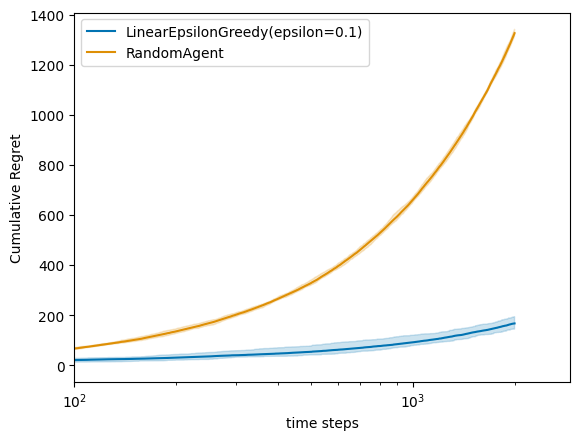

In [ ]:
# Hidden parameter theta
np.random.seed(0)
theta_true = np.random.uniform(-1, 1, size=5)
theta_true /= np.linalg.norm(theta_true)  # Normalize theta

# Environment setup
K = 10
T = 1000
Nmc = 10  # Number of Monte Carlo runs

# Create the environment
env = LinearBandit(theta=theta_true, K=K, var=1.0)

# Instantiate agents
epsilon_greedy_agent = LinearEpsilonGreedy(d=5, epsilon=0.1)
random_agent = RandomAgent()

agents = [epsilon_greedy_agent, random_agent]

# Run the experiment
results = experiment(env, agents, Nmc, T)

# Plot cumulative regret
plot_regret(results, logscale=True)


In [30]:
results['LinearEpsilonGreedy(epsilon=0.1)'].shape

(10, 2000)

In [32]:
results_short = {key:value[:,:10] for key, value in results.items()}
results_short

{'LinearEpsilonGreedy(epsilon=0.1)': array([[ 0.00000000e+00,  1.01455959e+00,  1.51537720e+00,
          5.66669912e-01,  4.35802349e-01,  2.47574533e-01,
          1.17339799e+00,  1.30903706e+00,  1.14364673e+00,
          0.00000000e+00],
        [ 7.92695429e-01,  0.00000000e+00,  1.04623399e+00,
          8.50736926e-01,  2.26960017e-01,  7.13566153e-01,
          1.11022302e-16,  1.45019538e-01,  1.37730188e-01,
          3.07825826e-01],
        [ 2.07866528e-01, -1.11022302e-16,  1.32022757e+00,
          6.96639028e-01,  1.12795153e+00,  0.00000000e+00,
          4.61779755e-01,  1.18688878e+00,  0.00000000e+00,
          1.44449802e-02],
        [ 1.17290720e+00,  0.00000000e+00,  6.27340418e-02,
          9.36167310e-02,  0.00000000e+00,  6.96184059e-01,
          1.11022302e-16,  2.09742042e-01,  3.27587212e-01,
          4.04446266e-01],
        [ 1.29571017e+00,  1.11022302e-16,  0.00000000e+00,
          4.41815317e-01,  4.07424179e-01,  2.99080643e-01,
          8.9928

C:\Users\julie\AppData\Local\Temp\ipykernel_28864\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


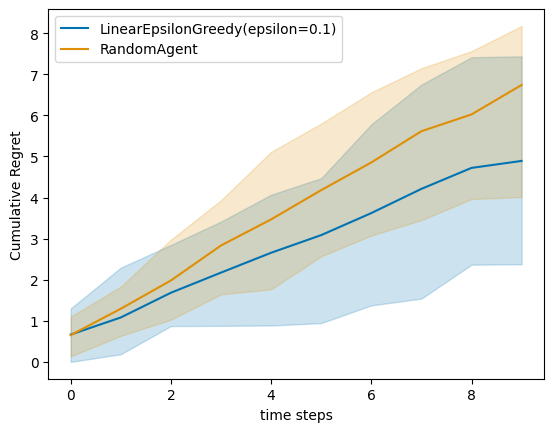

In [33]:
plot_regret(results_short, logscale=False)

In [15]:
results

{'RandomAgent': array([[-0.30075352, -0.30075352, -0.86969759, -0.86969759, -0.04331178,
         -0.38321439, -0.38321439, -0.86969759,  0.0666651 ,  0.0666651 ,
         -0.04331178,  0.0666651 , -0.86969759, -0.86969759, -0.30075352,
          0.0666651 ,  0.0666651 , -0.04331178, -0.04331178,  0.0666651 ,
         -0.86969759, -0.86969759, -0.86969759, -0.86969759, -0.86969759,
         -0.86969759, -0.38321439, -0.30075352,  0.0666651 , -0.38321439,
          0.0666651 ,  0.0666651 , -0.30075352, -0.86969759,  0.0666651 ,
         -0.86969759, -0.38321439,  0.0666651 , -0.30075352, -0.38321439,
         -0.86969759, -0.86969759, -0.04331178, -0.38321439, -0.04331178,
         -0.38321439, -0.30075352, -0.86969759, -0.04331178, -0.86969759,
         -0.30075352, -0.38321439, -0.04331178, -0.86969759,  0.0666651 ,
         -0.86969759,  0.0666651 , -0.04331178, -0.30075352, -0.30075352,
         -0.86969759, -0.86969759, -0.30075352, -0.30075352,  0.0666651 ,
         -0.38321439, -

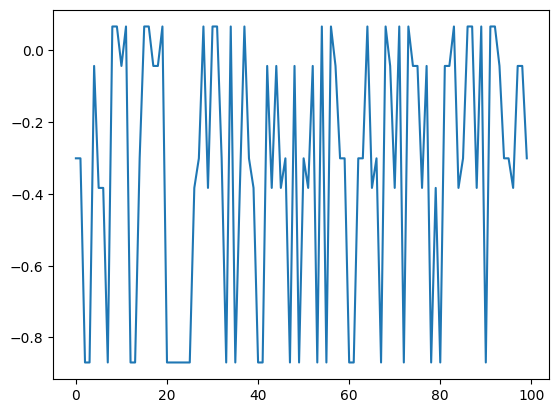

In [17]:
plt.plot(results['RandomAgent'][0])


## LinUCB : Implementing optimism in $R^d$

As seen in class, the actions are now vectors in $R^d$, representing contextual features, and the environment is assumed to generate rewards according to some hidden linear function $f_\theta(a) = a^\top \theta$. The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space.

* **Baseline: Implementation of LinEpsilonGreedy** In the next cell, we implemented a LinUniform Agent that returns one of the action vectors of the action set, chosen uniformly at random. Please implement a `LinEpsilonGreedy` agent and test it against `Greedy` ($\epsilon=0$) on the 2 proposed  environments (iid and fixed actions). What do you notice? Is $\epsilon$-Greedy a good baseline to test algorithms?


* **Implementation of LinUCB**: you need to compute UCBs for each arm of the current action set received from the environment, but this time the exploration bonus depends on the history of taken actions and received rewards (see course material).

* **Efficiency of the matrix inversion step**: One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. Remark however that at round $t+1$, the new covariance matrix is very similar to the previous one at rount $t$... Can you think of a way to optimize this step by simply updating the old one ? Please implement this improvement as an additional option to your `LinUCB` agent so you can compare runtimes from bandit problems in dimension $d=2,8,16,32,64$. Plot the result of the compared runtimes. In your report,  discuss the computational complexity of this step and the resulting improvement, give your new update formula, and report the plot of compared runtimes.

### Uniform random policy

In [40]:
class LinUniform:
  def __init__(self):
    pass

  def get_action(self, arms):
    K, _ = arms.shape
    return arms[np.random.choice(K)]

  def receive_reward(self, chosen_arm, reward):
    pass

  def reset(self):
    pass

  def name(self):
    return 'Unif'



### Lin-$\epsilon$-Greedy policy:

In [168]:
from numpy.linalg import pinv
import numpy as np

class LinEpsilonGreedy:
    def __init__(self, d, lambda_reg, eps=0.1, beta=1):
        """
        Linear Epsilon Greedy Agent
        
        Parameters:
            d (int): Dimension of the action vectors.
            lambda_reg (float): Regularization parameter for ridge regression.
            eps (float): Exploration probability.
        """
        self.eps_init = eps
        self.eps = eps  # Exploration probability
        self.d = d  # Dimension of the action space
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.beta = beta
        self.reset()

    def reset(self):
        """
        Reset all estimators and counts.
        This is used between independent experiments.
        """
        self.t = 0
        self.hat_theta = np.zeros(self.d)  # Estimate of theta
        self.cov = self.lambda_reg * np.identity(self.d)  # Regularized covariance matrix
        self.invcov = np.linalg.inv(self.cov)  # Inverse covariance matrix
        self.b_t = np.zeros(self.d)  # Reward-weighted sum of actions
        self.eps = self.eps_init

    def get_action(self, arms):
        """
        Select an action using epsilon-greedy strategy.
        
        Parameters:
            arms (np.ndarray): Set of actions, shape (K, d).
        
        Returns:
            np.ndarray: Chosen action vector.
        """
        K, _ = arms.shape
        # Epsilon-greedy strategy
        if np.random.rand() < self.eps:
            # Exploration: Choose a random arm
            return arms[np.random.choice(K)]
        else:
            # Exploitation: Choose the arm with maximum estimated reward
            estimated_rewards = arms @ self.hat_theta  # Dot product with current estimate
            return arms[np.argmax(estimated_rewards)]

    def receive_reward(self, chosen_arm, reward):
        """
        Update the internal quantities required to estimate the parameter theta using least squares.
        
        Parameters:
            chosen_arm (np.ndarray): Chosen action vector.
            reward (float): Observed reward.
        """
        chosen_arm = chosen_arm.reshape(-1, 1)  # Ensure the action is a column vector
        
        # Update inverse covariance matrix using Sherman-Morrison formula
        denominator = 1 + chosen_arm.T @ self.invcov @ chosen_arm
        self.invcov -= (self.invcov @ chosen_arm @ chosen_arm.T @ self.invcov) / denominator

        # Update b_t
        self.b_t += reward * chosen_arm.flatten()

        # Update the least squares estimate
        self.hat_theta = self.invcov @ self.b_t

        self.t += 1
        
        self.eps = self.eps * self.beta

    def name(self):
        return f'LinEGreedy(eps={self.eps})'


### Default setting

Quick test: I propose some simple settings to run a quick test.
For your report, feel free to change these and explain / justify your choices.
Please report the resulting plot and your conclusions on Lin-E-Greedy.

In [ ]:
d = 3  # dimension
K = 7  # number of arms

# parametor vector \theta, normalized :
theta = ActionsGenerator(1,d)[0] # another way of getting a 'random vector' (depends on your implementation)
# theta = np.array([0.45, 0.5, 0.5])
#theta /= np.linalg.norm(theta)

T = 1000
# Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1 # could be set directly in the algorithms
sigma = 1.

#choice of percentile display
q = 10


In [218]:
env = LinearBandit(theta, K, var=sigma**2)

In [219]:
def ActionsGenerator(K, d):
    # Generate actions close to a specific direction (e.g., [1, 1, ..., 1])
    base_direction = np.ones(d) / np.sqrt(d)
    actions = base_direction + 0.1 * np.random.normal(size=(K, d))
    actions /= np.linalg.norm(actions, axis=1, keepdims=True)
    return actions


In [220]:
def ActionsGenerator(K, d, bias_ratio=1):
    """
    Generate a biased set of actions where most actions are clustered around a specific direction,
    and a few are uniformly distributed.
    
    Parameters:
        K (int): Number of actions to generate.
        d (int): Dimension of the action vectors.
        bias_ratio (float): Proportion of actions that are biased (0.0 to 1.0).
        
    Returns:
        np.ndarray: A (K, d) array of action vectors.
    """
    num_biased = int(K * bias_ratio)
    num_uniform = K - num_biased

    # Generate biased actions near a specific direction
    base_direction = np.ones(d) / np.sqrt(d)  # Example direction: [1, 1, ..., 1]
    biased_actions = base_direction + 0.05 * np.random.normal(size=(num_biased, d))
    biased_actions /= np.linalg.norm(biased_actions, axis=1, keepdims=True)

    # Generate a few uniform actions on the unit sphere
    uniform_actions = InitActionsGenerator(num_uniform, d)

    # Combine both sets of actions
    actions = np.vstack((biased_actions, uniform_actions))
    np.random.shuffle(actions)  # Shuffle to mix biased and uniform actions
    return actions


In [221]:
# policies

uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)

C:\Users\julie\AppData\Local\Temp\ipykernel_28864\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


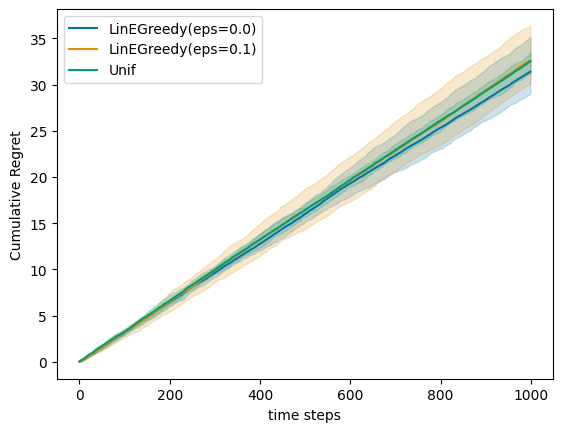

In [222]:
exp = experiment(env, [greedy, e_greedy, uniform], Nmc=N, T=T,pseudo_regret=True)
plot_regret(exp)

In [232]:
def ActionsGenerator(K,d, mean=None):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """
    actions = np.random.normal(size=(K, d))
    norms = np.linalg.norm(actions, axis=1, keepdims=True)
    unit_sphere_actions = actions / norms
    
    if mean is not None:
        mean = np.asarray(mean)
        if mean.shape != (d,):
            raise ValueError(f"'mean' must be of shape ({d},), got {mean.shape}")
        unit_sphere_actions += mean
    
    return unit_sphere_actions



C:\Users\julie\AppData\Local\Temp\ipykernel_28864\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


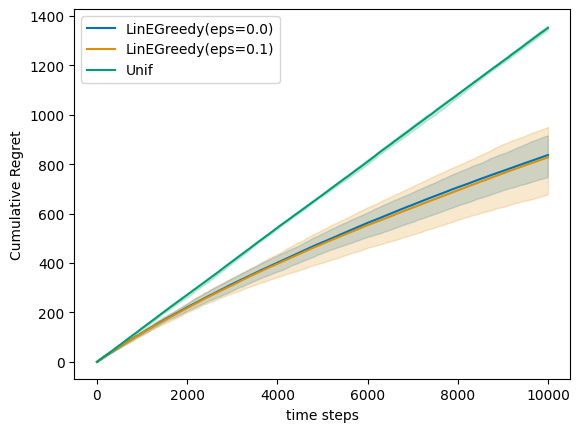

In [210]:
exp = experiment(env, [greedy, e_greedy, uniform], Nmc=N, T=T,pseudo_regret=True)
plot_regret(exp)

Is Lin-E-Greedy a strong baseline? Is it hard to beat?

## Lin-UCB: The optimistic way

**Implement LinUCB** as seen in class and test it against the baselines implemented above.

If you are happy with the result, move to the last part below.


In [226]:
class LinUCB:
    def __init__(self, d, delta, sigma=1.0, lambda_reg=1.0):
        """
        LinUCB Agent with confidence level determined by delta.
        
        Parameters:
            d (int): Dimension of the action vectors.
            delta (float): Confidence level (small value, e.g., 0.1 or 0.05).
            sigma (float): Standard deviation of noise in rewards.
            lambda_reg (float): Regularization parameter for ridge regression.
        """
        self.d = d  # Dimension of the action space
        self.delta = delta  # Confidence level
        self.sigma = sigma  # Noise standard deviation
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.alpha = self.compute_alpha()  # Exploration-exploitation tradeoff
        self.reset()

    def compute_alpha(self):
        """
        Compute the alpha parameter based on delta, sigma, and lambda_reg.
        """
        return self.sigma * np.sqrt(2 * np.log(1 / self.delta)) + np.sqrt(self.lambda_reg)

    def reset(self):
        """
        Reset all estimators and counts.
        This is used between independent experiments.
        """
        self.t = 0  # Time step
        self.hat_theta = np.zeros(self.d)  # Estimate of theta
        self.cov = self.lambda_reg * np.identity(self.d)  # Regularized covariance matrix
        self.invcov = np.linalg.inv(self.cov)  # Inverse covariance matrix
        self.b_t = np.zeros(self.d)  # Reward-weighted sum of actions

    def get_action(self, arms):
        """
        Select an action using LinUCB strategy.
        
        Parameters:
            arms (np.ndarray): Set of actions, shape (K, d).
        
        Returns:
            np.ndarray: Chosen action vector.
        """
        K, _ = arms.shape
        ucb_values = np.zeros(K)
        
        for i in range(K):
            arm = arms[i].reshape(-1, 1)  # Action as a column vector
            mean_reward = (arm.T @ self.hat_theta).flatten()  # Predicted reward
            confidence = self.alpha * np.sqrt(arm.T @ self.invcov @ arm)  # Confidence bound
            ucb_values[i] = mean_reward + confidence

        # Select the action with the highest UCB value
        chosen_action = arms[np.argmax(ucb_values)]
        return chosen_action

    def receive_reward(self, chosen_arm, reward):
        """
        Update the internal quantities required to estimate the parameter theta using least squares.
        
        Parameters:
            chosen_arm (np.ndarray): Chosen action vector.
            reward (float): Observed reward.
        """
        chosen_arm = chosen_arm.reshape(-1, 1)  # Ensure the action is a column vector

        # Update inverse covariance matrix using Sherman-Morrison formula
        denominator = 1 + chosen_arm.T @ self.invcov @ chosen_arm
        self.invcov -= (self.invcov @ chosen_arm @ chosen_arm.T @ self.invcov) / denominator

        # Update b_t
        self.b_t += reward * chosen_arm.flatten()

        # Update the least squares estimate
        self.hat_theta = self.invcov @ self.b_t

        self.t += 1

    def name(self):
        return f'LinUCB(delta={self.delta}, sigma={self.sigma})'


### Test against baselines

In [233]:
iid_env = LinearBandit(theta, K, var=sigma**2)

In [234]:
# policies

linucb = LinUCB(d, delta, sigma=sigma, lambda_reg=1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)


In [238]:
d = 30  # dimension
K = 7  # number of arms

# parametor vector \theta, normalized :
theta = ActionsGenerator(1,d)[0] # another way of getting a 'random vector' (depends on your implementation)
# theta = np.array([0.45, 0.5, 0.5])
#theta /= np.linalg.norm(theta)

T = 1000
# Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1 # could be set directly in the algorithms
sigma = 1.

#choice of percentile display
q = 10


C:\Users\julie\AppData\Local\Temp\ipykernel_28864\45315245.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ucb_values[i] = mean_reward + confidence
C:\Users\julie\AppData\Local\Temp\ipykernel_28864\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


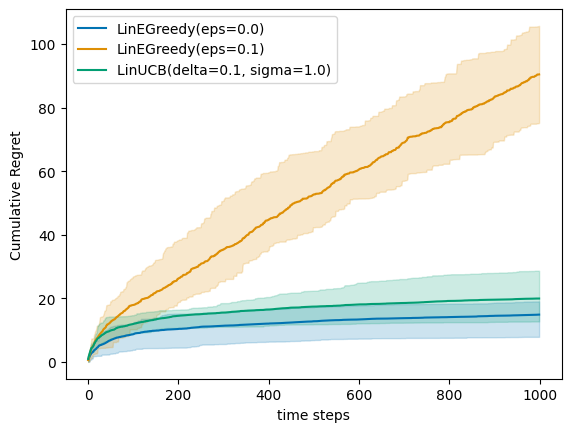

In [239]:
linucb_vs_greedy = experiment(iid_env, [greedy, e_greedy, linucb], Nmc=N, T=T,pseudo_regret=True)
plot_regret(linucb_vs_greedy)

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions.

* **Posterior derivation**: Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\lambda I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ?

In your report, write the distribution of the posterior as a function of the prior and the observed data. No need to report your full derivation if you are lacking space.


* **Implementation of LinTS**. Please implement Linear Thompson Sampling using the formula you derived above.

In [240]:
# class LinTS ... (use you LinUCB template)
class LinTS:
    def __init__(self, d, lambda_reg=1.0, sigma=1.0):
        """
        Linear Thompson Sampling Agent
        
        Parameters:
            d (int): Dimension of the action vectors.
            lambda_reg (float): Regularization parameter for prior covariance.
            sigma (float): Standard deviation of noise in rewards.
        """
        self.d = d  # Dimension of action space
        self.lambda_reg = lambda_reg  # Prior covariance parameter
        self.sigma = sigma  # Standard deviation of noise
        self.reset()

    def reset(self):
        """
        Reset all estimators and counts.
        This is used between independent experiments.
        """
        self.t = 0  # Time step
        self.A = self.lambda_reg * np.identity(self.d)  # Regularized covariance matrix
        self.b = np.zeros(self.d)  # Reward-weighted sum of actions

    def get_action(self, arms):
        """
        Select an action using Thompson Sampling.
        
        Parameters:
            arms (np.ndarray): Set of actions, shape (K, d).
        
        Returns:
            np.ndarray: Chosen action vector.
        """
        # Posterior mean and covariance
        posterior_cov = np.linalg.inv(self.A)
        posterior_mean = posterior_cov @ self.b

        # Sample from the posterior
        sampled_theta = np.random.multivariate_normal(posterior_mean, posterior_cov)

        # Select the action that maximizes the sampled reward
        ucb_values = arms @ sampled_theta
        chosen_action = arms[np.argmax(ucb_values)]
        return chosen_action

    def receive_reward(self, chosen_arm, reward):
        """
        Update the posterior distribution based on the observed reward.
        
        Parameters:
            chosen_arm (np.ndarray): Chosen action vector.
            reward (float): Observed reward.
        """
        chosen_arm = chosen_arm.reshape(-1, 1)  # Ensure the action is a column vector

        # Update the covariance matrix
        self.A += chosen_arm @ chosen_arm.T

        # Update the reward-weighted sum of actions
        self.b += reward * chosen_arm.flatten()

    def name(self):
        return "LinTS"



In [245]:
# policies

linucb = LinUCB(d, delta, sigma=sigma, lambda_reg=1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)
lints = LinTS(d, lambda_reg=1., sigma=sigma)

In [280]:
d = 30  # dimension
K = 7  # number of arms

# parametor vector \theta, normalized :
theta = ActionsGenerator(1,d)[0] # another way of getting a 'random vector' (depends on your implementation)
# theta = np.array([0.45, 0.5, 0.5])
#theta /= np.linalg.norm(theta)

T = 1000
# Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1 # could be set directly in the algorithms
sigma = 1.

#choice of percentile display
q = 10


C:\Users\julie\AppData\Local\Temp\ipykernel_28864\45315245.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ucb_values[i] = mean_reward + confidence
C:\Users\julie\AppData\Local\Temp\ipykernel_28864\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


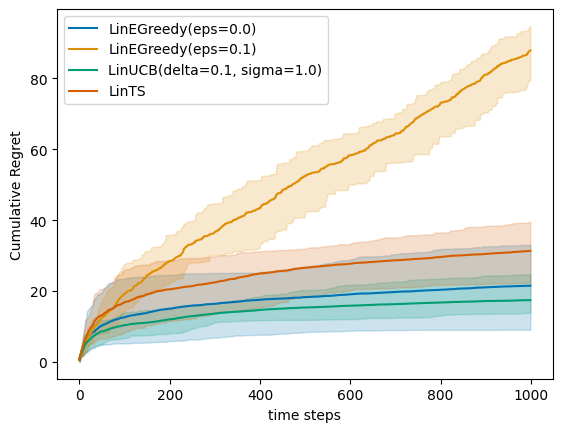

In [281]:
linucb_vs_greedy = experiment(iid_env, [greedy, e_greedy, linucb, lints], Nmc=N, T=T,pseudo_regret=True)
plot_regret(linucb_vs_greedy)

In [266]:
fixedenv = LinearBandit(theta, K, var=sigma**2, fixed_actions=ActionsGenerator(K, d))

In [267]:
linucb = LinUCB(d, delta, sigma=sigma, lambda_reg=1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)
lints = LinTS(d, lambda_reg=1., sigma=sigma)

In [272]:
d = 300  # dimension
K = 7  # number of arms

# parametor vector \theta, normalized :
theta = ActionsGenerator(1,d)[0] # another way of getting a 'random vector' (depends on your implementation)
# theta = np.array([0.45, 0.5, 0.5])
#theta /= np.linalg.norm(theta)

T = 100
# Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1 # could be set directly in the algorithms
sigma = 1.

#choice of percentile display
q = 10


C:\Users\julie\AppData\Local\Temp\ipykernel_28864\45315245.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ucb_values[i] = mean_reward + confidence
C:\Users\julie\AppData\Local\Temp\ipykernel_28864\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


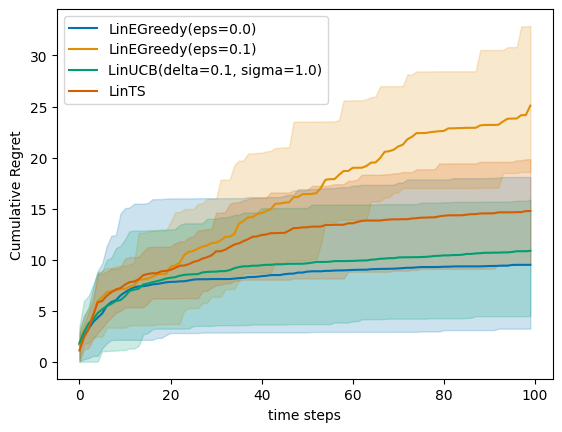

In [273]:
linucb_vs_greedy = experiment(fixedenv, [greedy, e_greedy, linucb, lints], Nmc=N, T=T,pseudo_regret=True)
plot_regret(linucb_vs_greedy)

C:\Users\julie\AppData\Local\Temp\ipykernel_28864\45315245.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ucb_values[i] = mean_reward + confidence
C:\Users\julie\AppData\Local\Temp\ipykernel_28864\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


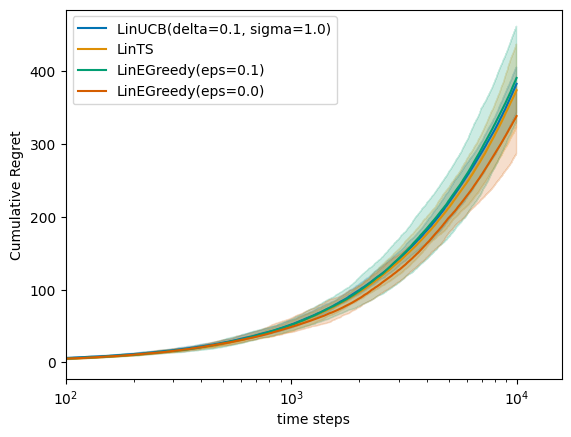

In [297]:
def BiasedActionsGenerator(K, d, bias_ratio=0.9):
    num_biased = int(K * bias_ratio)
    num_uniform = K - num_biased

    base_direction = np.zeros(d)
    base_direction[0] = 1
    biased_actions = base_direction + 0.05 * np.random.normal(size=(num_biased, d))
    biased_actions /= np.linalg.norm(biased_actions, axis=1, keepdims=True)

    optimal_action = np.zeros(d)
    optimal_action[1] = 1
    optimal_actions = [optimal_action] * num_uniform

    actions = np.vstack((biased_actions, optimal_actions))
    np.random.shuffle(actions)
    return actions

def VeryBiasedActionsGenerator(K, d, bias_ratio=0.95):
    num_biased = int(K * bias_ratio)
    biased_actions = np.zeros((num_biased, d))
    biased_actions[:, 0] = 1  # Toutes les actions biaisées pointent dans la même direction
    optimal_actions = np.random.normal(size=(K - num_biased, d))
    optimal_actions /= np.linalg.norm(optimal_actions, axis=1, keepdims=True)
    return np.vstack((biased_actions, optimal_actions))


# Biased Environment
class BiasedLinearBandit:
    def __init__(self, theta, K, d, var=1.0, bias_ratio=0.9):
        self.theta = theta
        self.K = K
        self.d = d
        self.var = var
        self.bias_ratio = bias_ratio
        self.current_action_set = np.zeros(self.d)

    def get_action_set(self):
        self.current_action_set = VeryBiasedActionsGenerator(self.K, self.d, self.bias_ratio)
        return self.current_action_set

    def get_reward(self, action):
        mean_reward = np.dot(action, self.theta)
        return np.random.normal(mean_reward, scale=self.var)

    def get_means(self):
        return self.current_action_set @ self.theta
    



# Parameters
d, K, T, N = 50, 10, 10000, 10
theta = np.zeros(d)
theta[1] = 1
biased_env = BiasedLinearBandit(theta=theta, K=K, d=d, var=2.0, bias_ratio=0.99)

# Agents
e_greedy = LinEpsilonGreedy(d, lambda_reg=1.0, eps=0.1)
lin_ucb = LinUCB(d, delta=0.1, sigma=1.0, lambda_reg=1.0)
lin_ts = LinTS(d, lambda_reg=1.0, sigma=1.0)
greedy = LinEpsilonGreedy(d, lambda_reg=1.0, eps=0.0)

agents = [lin_ucb, lin_ts, e_greedy, greedy]

# Run experiment and plot
regrets = experiment(biased_env, agents, Nmc=N, T=T)
plot_regret(regrets, logscale=True)

### Comparison and report

Compare LinUCB, LinTS and LinEGreedy on a problem of your choice. In your report, explain your choice of problem and report the plot of your experiment as well as a few sentences of comment: Is there a clear 'winner'?

#Bonus

In this bonus part, we explore the role of the action sets on the performance of our algorithms.

In class we said that action sets can be 'arbitrary'. This means that, in principle, they do not have to follow a distribution, they do not have to be random either.

What happens if the action set is fixed?

We propose an alternative 'play' function that fixes the action set:

In [250]:
def play_fixed(environment, agent, Nmc, T, actions=None, pseudo_regret=True):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    actions: a fixed action set. Default is set to be the canonical basis.
    """

    data = np.zeros((Nmc, T))

    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            # action_set = environment.get_action_set() -> We no longer call on your ActionsGenerator function
            action_set = np.copy(actions) # the actions given as input
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            if pseudo_regret:
              data[n,t] = best_reward - np.dot(environment.theta,action)
            else:
              data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive

    return agent.name(), data

In [251]:
def experiment_fixed(environment, agents, Nmc, T, actions=None, pseudo_regret=True):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}
    if actions is None:
      actions = ActionsGenerator(K,d) #call it once!
    print(actions)

    for agent in agents:
        agent_id, regrets = play_fixed(environment, agent, Nmc, T, actions=actions, pseudo_regret=pseudo_regret)

        all_data[agent_id] = regrets

    return all_data

Now the actions are fixed, so we could actually use UCB to address the problem: after all, it is just a K-armed bandit, but with structure.

**When is LinUCB better than UCB?**

In [252]:
class UCB:
  def __init__(self, K, var):
      self.K = K
      self.var = var
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0

  def get_action(self,action_set):
      if self.t < self.K:
        action = self.t
      else:
        empirical_means = self.count_rewards / self.count_actions
        ucbs = np.sqrt(6 * self.var * np.log(self.t) / self.count_actions) # 6 could be replaced by a 2, try it out :)
        action = np.argmax(empirical_means + ucbs)

      self.t += 1
      self.count_actions[action] += 1
      self.current_action = action #need to remember the *index* of the action now
      return action_set[action,:]

  def receive_reward(self, action, reward):
      self.count_rewards[self.current_action] += reward

  def reset(self):
      self.count_actions = np.zeros(self.K)
      self.count_rewards = np.zeros(self.K)
      self.t = 0

  def name(self):
      return 'UCB('+str(self.var)+')'

In [263]:
d=3
K=7 # same as before, more actions than dimension
theta = np.random.normal(size=d)

env = LinearBandit(theta, K)
ucb = UCB(K,var=1.)
linucb = LinUCB(d, delta=0.01, lambda_reg=1., sigma=1. )
reg_fixed_actions = experiment_fixed(env, [ucb, linucb], Nmc=10, T=200, actions=None, pseudo_regret=True)

[[-0.39823171 -0.71525123 -0.57430582]
 [ 0.39128444  0.57440592 -0.71899536]
 [-0.67885982  0.20345684  0.7055173 ]
 [ 0.09665114  0.2859425  -0.95336008]
 [-0.35050031  0.19947082  0.91507427]
 [ 0.56423786  0.40161897 -0.72134447]
 [-0.63955126 -0.61081532  0.46677493]]


C:\Users\julie\AppData\Local\Temp\ipykernel_28864\45315245.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ucb_values[i] = mean_reward + confidence


C:\Users\julie\AppData\Local\Temp\ipykernel_28864\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


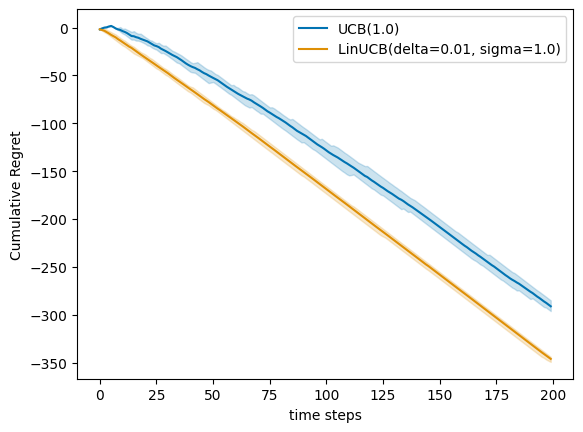

In [264]:
plot_regret(reg_fixed_actions)

In general, LinUCB is better in such problem because it shares information across actions.

Now, what if K=d and the fixed action set is exactly the canonical basis (K=d independent actions)

In [ ]:
d=7
K=d
# theta = np.random.multivariate_normal(np.zeros(d),np.eye(d))
theta = np.linspace(0.1,1,num=d) # just d actions in increasing value order
#theta = your choice of parameter
theta /= np.linalg.norm(theta) #optional if you set theta with bounded norm :)

env = LinearBandit(theta, d, fixed_actions=np.eye(d))
ucb = UCB(d,var=1.)
linucb = LinUCB(d, delta=0.01, lambda_reg=1., sigma=1. )
reg_fixed_actions = experiment_fixed(env, [ucb, linucb], Nmc=10, T=200, actions=np.eye(d), pseudo_regret=True)

In [ ]:
plot_regret(reg_fixed_actions)

The two algorithms should be roughly on par. In fact, it is possible to refine UCB to get slightly better performance (by tightening a bit the upper confidence bounds).

In "[The End of Optimism](https://arxiv.org/pdf/1610.04491)", Lattimore et al. show that for a certain type of action set, one can show that UCB has **linear regret**. A famous 'counter-example' (bad action set) is given in Section 8 therein.

**Exercise**: find the action set (3 actions in dimension 2) and run the experiment above, what do you see? In (the appendix of) your report, please report your figures and conclusions.

The problem of finding a good algorithm for the 'arbitrary' setting and the 'fixed-design' setting was open for a long time but recent papers (e.g. [Kirschner et al.,2021](https://arxiv.org/abs/2011.05944)) have now proposed solutions.